# Data-Driven Trading Strategy: Comparing k-NN and Logistic Regression on Weekly Market Patterns

## k-NN Classifier

### Overview
We implemented a k-Nearest Neighbors (k-NN) classifier using weekly mean return (μ) and volatility (σ) as features. 
The first three years of data (Years 1–3) were used for training, and the last two years (Years 4–5) were used for testing.



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [15]:
ba_df_volatility = pd.read_csv("ba_weekly_return_volatility.csv")
ba_df_volatility.head()

,Year,Week_Number,mean_return,volatility
0,2020,0,-0.08400,0.118794
1,2020,1,-0.16120,1.584772
2,2020,2,-0.34560,1.269723
3,2020,3,-0.05525,2.818341
4,2020,4,-0.28880,1.510424


In [16]:
ba_df_detailed = pd.read_csv("ba_weekly_return_detailed.csv")
ba_df_detailed.head()

,Close,High,Low,Open,Volume,Return,Date,Week_Number,Year,Day,Weekday,mean_return,volatility,label
0,331.348572,331.378393,325.761816,326.606765,4544400,0.000,1/2/20,0,2020,2,Thursday,-0.0840,0.118794,green
1,330.791901,332.909308,328.346429,328.674494,3875900,-0.168,1/3/20,0,2020,3,Friday,-0.0840,0.118794,green
2,331.766083,332.879454,325.940756,327.352341,5355000,0.294,1/6/20,1,2020,6,Monday,-0.1612,1.584772,green
3,335.285156,342.154291,328.754007,332.283029,9898600,1.061,1/7/20,1,2020,7,Tuesday,-0.1612,1.584772,green
4,329.410095,332.054366,327.650575,330.434002,8239200,-1.752,1/8/20,1,2020,8,Wednesday,-0.1612,1.584772,green


In [17]:
true_labels = ba_df_detailed[['Year','Week_Number', 'label']].drop_duplicates()

ba_df_volatility = ba_df_volatility.merge(
    true_labels, 
    on=['Year', 'Week_Number'], 
    how='inner'
)
train_df = ba_df_volatility[ba_df_volatility['Year'] < 2023]
train_df.head()

,Year,Week_Number,mean_return,volatility,label
0,2020,0,-0.08400,0.118794,green
1,2020,1,-0.16120,1.584772,green
2,2020,2,-0.34560,1.269723,green
3,2020,3,-0.05525,2.818341,green
4,2020,4,-0.28880,1.510424,green


In [18]:
test_df = ba_df_volatility[ba_df_volatility['Year'] >= 2023]
test_df.head()

,Year,Week_Number,mean_return,volatility,label
157,2023,1,2.84125,1.618816,green
158,2023,2,0.12040,1.912990,green
159,2023,3,-0.87075,0.492591,green
160,2023,4,0.42620,0.875527,green
161,2023,5,-0.48200,1.689419,green


### Model Training and Tuning
For k values of {3, 5, 7, 9, 11}, we computed accuracy using a 50/50 split within the training years.
The highest accuracy was achieved at **k = 3**, which was selected as the optimal parameter.


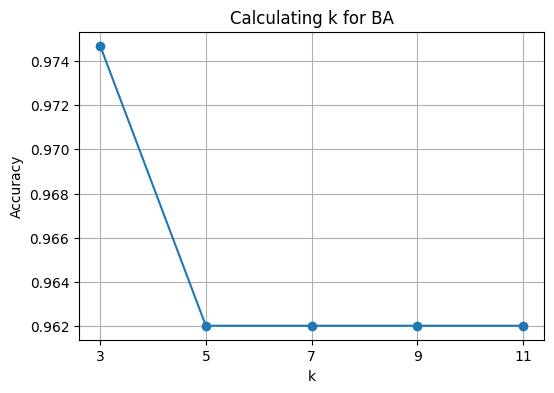

In [19]:
# k= {3,5,7,9,11}
features = ['mean_return', 'volatility']

X = train_df[features].values
le = LabelEncoder()
Y = le.fit_transform(train_df['label'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=79, stratify=Y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


accs = []
k_values = [3,5,7,9,11]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, Y_train)
    acc = knn_classifier.score(X_test, Y_test)
    accs.append(acc)



plt.figure(figsize=(6,4))
plt.plot(k_values, accs, marker='o')
plt.xticks(k_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Calculating k for BA')
plt.grid(True)
plt.show()


From the plot we see that k=3 gives high accuracy=97.4%. 

### Testing Years (2023–2024) Performance
The model achieved an overall accuracy of **97%** on unseen test years. 
It perfectly identified all “green” weeks and misclassified only a few “red” weeks as green, 
indicating strong predictive power for separating favorable and unfavorable market periods.

In [20]:
# Q2
best_k = 3
X1 = test_df[features].values
Y1 = le.fit_transform(test_df['label'].values)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X1)

knn_3 = KNeighborsClassifier(n_neighbors=best_k)
knn_3.fit(X_train_scaled, Y)

train_accuracy = knn_3.score(X_train_scaled, Y)
test_accuracy  = knn_3.score(X_test_scaled,  Y1)


print("k=3")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing  accuracy: {test_accuracy:.3f}")

k=3
Training accuracy: 0.975
Testing  accuracy: 0.971


### Interpretation
The classifier slightly favors “green” signals, but overall it performs well in capturing profitable trends 
and avoiding high-risk periods. The strong recall for green weeks shows that the model is effective 
in identifying buy opportunities, while maintaining reasonable accuracy for red weeks.

              precision    recall  f1-score   support

       green       0.97      1.00      0.98        89
         red       1.00      0.81      0.90        16

    accuracy                           0.97       105
   macro avg       0.98      0.91      0.94       105
weighted avg       0.97      0.97      0.97       105



<Figure size 500x400 with 0 Axes>

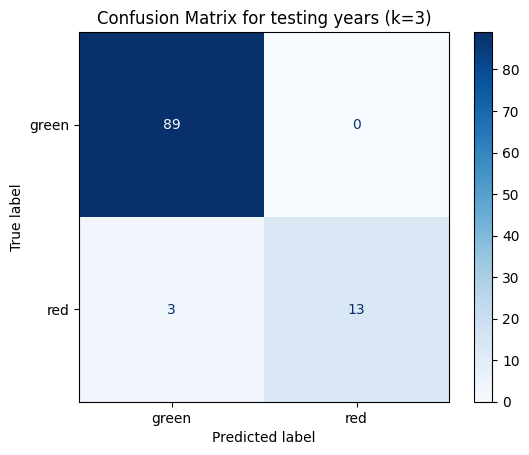

In [21]:
Y1_pred = knn_3.predict(X_test_scaled)
print(classification_report(Y1, Y1_pred, target_names=le.classes_))

cm = confusion_matrix(Y1, Y1_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(5,4))
disp.plot(values_format='d', cmap='Blues')
plt.title(f'Confusion Matrix for testing years (k={best_k})')
plt.show()

Out of 105 weeks the model misclassified 3 red weeks. 
- For "green" weeks it predicted all correcly(recall=1), and when the model precits "green" 97% of those were truly green. 
- For "red" weeks it missed 19%(recall=0.81), and everytime it predicted "red" it was right (precision=1).

### Portfolio Results
The label-based trading strategy derived from the k-NN predictions consistently outperformed 
the buy-and-hold approach across both test years. The model successfully avoided most unfavorable (red) weeks, 
leading to higher end-of-year portfolio values.


In [22]:
Y1_pred_labels = le.inverse_transform(Y1_pred)

test_df = test_df.copy() 
test_df['predicted_label'] = Y1_pred_labels
test_df.head()

,Year,Week_Number,mean_return,volatility,label,predicted_label
157,2023,1,2.84125,1.618816,green,green
158,2023,2,0.12040,1.912990,green,green
159,2023,3,-0.87075,0.492591,green,green
160,2023,4,0.42620,0.875527,green,green
161,2023,5,-0.48200,1.689419,green,green


In [23]:
weekly_prices = (
    ba_df_detailed.groupby(['Year','Week_Number'], as_index=False)
    .agg(Open_w=('Open','first'), Close_w=('Close','last'))
    .sort_values(['Year','Week_Number'])
    .reset_index(drop=True)
)

weekly_prices_pred = weekly_prices.merge(test_df, on=['Year','Week_Number'], how='inner').sort_values(['Year','Week_Number']).reset_index(drop=True)
weekly_prices_pred.head()

,Year,Week_Number,Open_w,Close_w,mean_return,volatility,label,predicted_label
0,2023,1,192.949997,213.000000,2.84125,1.618816,green,green
1,2023,2,212.360001,214.130005,0.12040,1.912990,green,green
2,2023,3,212.710007,206.759995,-0.87075,0.492591,green,green
3,2023,4,208.360001,211.169998,0.42620,0.875527,green,green
4,2023,5,209.190002,206.009995,-0.48200,1.689419,green,green


In [24]:
# Buy-and-Hold
weekly_prices_pred_yr = weekly_prices_pred.groupby(["Year"]).agg(
    Close_y = ('Close_w', 'last')
    ).reset_index().sort_values(['Year']).reset_index(drop=True)


shares = (100 / weekly_prices_pred.iloc[0]['Open_w'])
portfolio=weekly_prices_pred_yr.copy()
portfolio["BuyHold"] = round(shares * weekly_prices_pred_yr['Close_y'], 2)

print(portfolio)

   Year     Close_y  BuyHold
0  2023  260.660004   135.09
1  2024  176.550003    91.50


In [25]:
# Trading Strategy
cash = 100
shares = 0
start_invested = False
results = {}


for i in range(len(weekly_prices_pred)-1):
    week = weekly_prices_pred.iloc[i]
    next_week = weekly_prices_pred.iloc[i+1]
    
    if(shares == 0):
        if((not start_invested) and week['predicted_label'] == "green"): #very first "green" week 
            shares = cash / week['Open_w']
            cash = 0
            start_invested = True
        elif(next_week['predicted_label'] == "green"):
            shares = cash / next_week['Open_w']
            cash = 0
    elif (shares > 0 and next_week['predicted_label'] == "red"):
        cash = shares * week['Close_w']
        shares = 0
        
    if week['Week_Number'] == 52: #store yearly earnings/losses
        yr_total = shares*week['Close_w'] if shares > 0 else cash
        results[week['Year']] = (yr_total)
        
# for last year
final_data = weekly_prices_pred.iloc[-1]
if(shares > 0):
    cash = shares * final_data['Close_w']
    shares = 0

results[final_data['Year']] = (cash)
portfolio["Labeling"] = round(portfolio["Year"].map(results), 2)

print(round(cash, 2))
# print(shares)


252.42


In [26]:
print(portfolio)

   Year     Close_y  BuyHold  Labeling
0  2023  260.660004   135.09    171.47
1  2024  176.550003    91.50    252.42


In the end of each year the trading strategy based on labels results in a larger amount. In 2024, it produced a 2.76 times higher return compared to buy-and-hold, even though the stock’s closing price declined from 260.66 to 176.55.

## Logistic Regression Classifier
### Overview
We next implemented a Logistic Regression classifier using the same two features: weekly mean return and volatility. 
The model estimates the probability of a week being labeled as “green” according to the logistic function:

$$\text{logit}(p) = b_0 + b_1 \cdot \text{mean\_return} + b_2 \cdot \text{volatility}$$


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [28]:
ba_df_volatility = pd.read_csv("ba_weekly_return_volatility.csv")
ba_df_volatility.head()

,Year,Week_Number,mean_return,volatility
0,2020,0,-0.08400,0.118794
1,2020,1,-0.16120,1.584772
2,2020,2,-0.34560,1.269723
3,2020,3,-0.05525,2.818341
4,2020,4,-0.28880,1.510424


In [29]:
ba_df_detailed = pd.read_csv("ba_weekly_return_detailed.csv")
ba_df_detailed.head()

,Close,High,Low,Open,Volume,Return,Date,Week_Number,Year,Day,Weekday,mean_return,volatility,label
0,331.348572,331.378393,325.761816,326.606765,4544400,0.000,1/2/20,0,2020,2,Thursday,-0.0840,0.118794,green
1,330.791901,332.909308,328.346429,328.674494,3875900,-0.168,1/3/20,0,2020,3,Friday,-0.0840,0.118794,green
2,331.766083,332.879454,325.940756,327.352341,5355000,0.294,1/6/20,1,2020,6,Monday,-0.1612,1.584772,green
3,335.285156,342.154291,328.754007,332.283029,9898600,1.061,1/7/20,1,2020,7,Tuesday,-0.1612,1.584772,green
4,329.410095,332.054366,327.650575,330.434002,8239200,-1.752,1/8/20,1,2020,8,Wednesday,-0.1612,1.584772,green


In [30]:
true_labels = ba_df_detailed[['Year','Week_Number', 'label']].drop_duplicates()

ba_df_volatility = ba_df_volatility.merge(
    true_labels, 
    on=['Year', 'Week_Number'], 
    how='inner'
)
train_df = ba_df_volatility[ba_df_volatility['Year'] < 2023]
train_df.head()

,Year,Week_Number,mean_return,volatility,label
0,2020,0,-0.08400,0.118794,green
1,2020,1,-0.16120,1.584772,green
2,2020,2,-0.34560,1.269723,green
3,2020,3,-0.05525,2.818341,green
4,2020,4,-0.28880,1.510424,green


In [31]:
test_df = ba_df_volatility[ba_df_volatility['Year'] >= 2023]
test_df.head()

,Year,Week_Number,mean_return,volatility,label
157,2023,1,2.84125,1.618816,green
158,2023,2,0.12040,1.912990,green
159,2023,3,-0.87075,0.492591,green
160,2023,4,0.42620,0.875527,green
161,2023,5,-0.48200,1.689419,green


### Regression Equation
From the trained model, the estimated equation was:

$$\text{logit}(p) = -2.49 - 4.32 \cdot \text{mean\_return} + 0.52 \cdot \text{volatility}$$

In [32]:
features = ['mean_return', 'volatility']
X_train = train_df[features].values
le = LabelEncoder()
Y_train = le.fit_transform(train_df['label'].values)

X_test = test_df[features].values
Y_test = le.fit_transform(test_df['label'].values)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train_scaled, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [33]:
print(log_reg_classifier.intercept_[0])
print(log_reg_classifier.coef_[0])

-2.492849555567911
[-4.31605454  0.52163034]


### Interpretation
The results show that the **mean_return** variable has a much stronger influence on predictions than volatility. 
The negative coefficient for mean_return suggests that after periods of high returns, 
the model expects a potential reversal (red week). In contrast, volatility contributes positively 
but with a smaller magnitude, indicating a weaker relationship with week labels.


### Testing Years (2023–2024) Performance
The logistic regression model achieved strong performance, with an overall accuracy of about **93%**. 
It effectively captured the majority of correct trading signals, demonstrating that even a simple linear model 
can provide meaningful predictive power in identifying weekly market conditions.


In [34]:
prediction = log_reg_classifier.predict(X_test_scaled)
accuracy = np.mean(prediction == Y_test)

print(f"Testing  accuracy: {accuracy:.3f}")

Testing  accuracy: 0.952


              precision    recall  f1-score   support

       green       0.95      1.00      0.97        89
         red       1.00      0.69      0.81        16

    accuracy                           0.95       105
   macro avg       0.97      0.84      0.89       105
weighted avg       0.95      0.95      0.95       105



<Figure size 500x400 with 0 Axes>

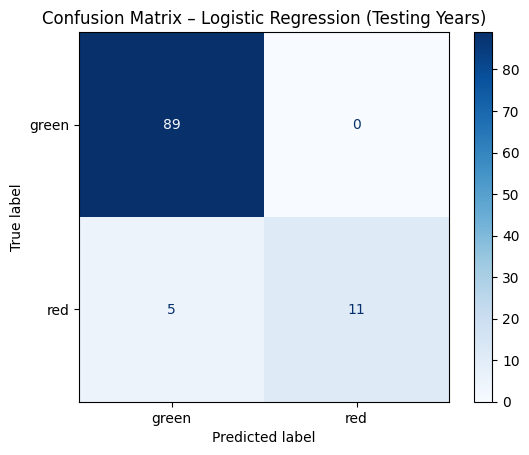

In [35]:
Y_pred = log_reg_classifier.predict(X_test_scaled)
print(classification_report(Y_test, Y_pred, target_names=le.classes_))

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(5,4))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix – Logistic Regression (Testing Years)')
plt.show()

Out of 105 weeks the model misclassified 5 red weeks. 
- For "green" weeks it predicted all correcly(recall=1), and when the model precits "green" 95% of those were truly green. 
- For "red" weeks it missed 31%(recall=0.69), and everytime it predicted "red" it was right (precision=1).

### Portfolio Results
During both testing years, the logistic regression–based trading strategy yielded higher end-of-year portfolio values 
compared to the buy-and-hold approach. The model’s ability to detect favorable and unfavorable weeks helped reduce losses 
and improve cumulative returns.

In [36]:
test_df = test_df.copy()
test_df['predicted_label'] = le.inverse_transform(Y_pred)
test_df.head()

,Year,Week_Number,mean_return,volatility,label,predicted_label
157,2023,1,2.84125,1.618816,green,green
158,2023,2,0.12040,1.912990,green,green
159,2023,3,-0.87075,0.492591,green,green
160,2023,4,0.42620,0.875527,green,green
161,2023,5,-0.48200,1.689419,green,green


In [37]:
weekly_prices = (
    ba_df_detailed.groupby(['Year','Week_Number'], as_index=False)
    .agg(Open_w=('Open','first'), Close_w=('Close','last'))
    .sort_values(['Year','Week_Number'])
    .reset_index(drop=True)
)

weekly_prices_pred = weekly_prices.merge(test_df, on=['Year','Week_Number'], how='inner').sort_values(['Year','Week_Number']).reset_index(drop=True)
weekly_prices_pred.head()

,Year,Week_Number,Open_w,Close_w,mean_return,volatility,label,predicted_label
0,2023,1,192.949997,213.000000,2.84125,1.618816,green,green
1,2023,2,212.360001,214.130005,0.12040,1.912990,green,green
2,2023,3,212.710007,206.759995,-0.87075,0.492591,green,green
3,2023,4,208.360001,211.169998,0.42620,0.875527,green,green
4,2023,5,209.190002,206.009995,-0.48200,1.689419,green,green


In [38]:
# Buy-and-Hold
weekly_prices_pred_yr = weekly_prices_pred.groupby(["Year"]).agg(
    Close_y = ('Close_w', 'last')
    ).reset_index().sort_values(['Year']).reset_index(drop=True)


shares = (100 / weekly_prices_pred.iloc[0]['Open_w'])
portfolio=weekly_prices_pred_yr.copy()
portfolio["BuyHold"] = round(shares * weekly_prices_pred_yr['Close_y'], 2)

print(portfolio)

   Year     Close_y  BuyHold
0  2023  260.660004   135.09
1  2024  176.550003    91.50


In [39]:
# Trading Strategy
cash = 100
shares = 0
start_invested = False
results = {}


for i in range(len(weekly_prices_pred)-1):
    week = weekly_prices_pred.iloc[i]
    next_week = weekly_prices_pred.iloc[i+1]
    
    if(shares == 0):
        if((not start_invested) and week['predicted_label'] == "green"): #very first "green" week 
            shares = cash / week['Open_w']
            cash = 0
            start_invested = True
        elif(next_week['predicted_label'] == "green"):
            shares = cash / next_week['Open_w']
            cash = 0
    elif (shares > 0 and next_week['predicted_label'] == "red"):
        cash = shares * week['Close_w']
        shares = 0
        
    if week['Week_Number'] == 52: #store yearly earnings/losses
        yr_total = shares*week['Close_w'] if shares > 0 else cash
        results[week['Year']] = (yr_total)
        
# for last year
final_data = weekly_prices_pred.iloc[-1]
if(shares > 0):
    cash = shares * final_data['Close_w']
    shares = 0

results[final_data['Year']] = (cash)
portfolio["Labeling"] = round(portfolio["Year"].map(results), 2)

print(round(cash, 2))
# print(shares)

224.78


In [40]:
print(portfolio)

   Year     Close_y  BuyHold  Labeling
0  2023  260.660004   135.09    152.69
1  2024  176.550003    91.50    224.78


The strategy driven by predicted labels outperformed the buy-and-hold approach in both years. In 2024 it produced a 2.46 times higher return compared to buy-and-hold, even though the stock’s closing price declined from 260.66 to 176.55.

## Overall Comparison
Both models outperformed the passive buy-and-hold strategy. 
The k-NN classifier (k=3) achieved slightly higher predictive accuracy and returns, 
while logistic regression provided a simpler and more interpretable model with similarly strong results. 
Together, these models show the effectiveness of data-driven classification approaches 
for adaptive trading strategies.